In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Seaborn color palette
cmap = sns.color_palette("Paired", 10)
sns.set_palette(cmap)

In [47]:
# Read in data
train1 = pd.read_csv("supplementary_materials/data/wine_training1.txt")
train2 = pd.read_csv("supplementary_materials/data/wine_training2.txt")
test1 = pd.read_csv("supplementary_materials/data/wine_testing.txt")
test2 = pd.read_csv("supplementary_materials/data/wine_testing.txt")

In [48]:
# Normalize
train1_mean = train1.ix[:, 1:].mean()
train2_mean = train2.ix[:, 1:].mean()
train1_std = train1.ix[:, 1:].std()
train2_std = train2.ix[:, 1:].std()
train1.ix[:, 1:] = (train1.ix[:, 1:] - train1_mean) / (train1_std)
train2.ix[:, 1:] = (train2.ix[:, 1:] - train2_mean) / (train2_std)
test1.ix[:, 1:] = (test1.ix[:, 1:] - train1_mean) / (train1_std)
test2.ix[:, 1:] = (test2.ix[:, 1:] - train2_mean) / (train2_std)

# Add bias column
train1.insert(1, 'x0', 1.0)
train2.insert(1, 'x0', 1.0)
test1.insert(1, 'x0', 1.0)
test2.insert(1, 'x0', 1.0)

In [49]:
def l2_logistic_grad(x, y, w, lam, N):
    return (2 * lam * w / N) - (y * x / (1 + np.exp(y * np.dot(w.T, x))))

def l2_logistic_error(X, Y, w, lam):
    assert len(X) == len(Y)
    error_sum = 0
    for i in range(len(X)):
        error_sum += l2_logistic_error_helper(X[i], Y[i], w, lam)
    return lam * np.dot(w.T, w) - error_sum

def l2_logistic_error_helper(x, y, w, lam):
    return np.log(1 / (1 + np.exp(-y * np.dot(w.T, x))))

In [94]:
def sgd(X, Y, reg_str, init_weights):
    assert len(X) == len(Y)
    weights = init_weights.copy()
    #print(weights)
    
    ### First epoch ###
    loss = l2_logistic_error(X, Y, weights, reg_str)
    
    for i in range(len(X)):
        update = l2_logistic_grad(X[i], Y[i], weights, reg_str, len(X))
        weights -= .01 * update
    new_loss = l2_logistic_error(X, Y, weights, reg_str)
    print('%f, %f' % (loss, new_loss))
    ep1_loss_red = 1 - new_loss / loss
    
    ### Other epochs ###
    loss_red = 1
    while loss_red > .00001 * ep1_loss_red:
        loss = new_loss
        for i in range(len(X)):
            update = l2_logistic_grad(X[i], Y[i], weights, reg_str, len(X))
            weights -= .01 * update
        new_loss = l2_logistic_error(X, Y, weights, reg_str)
        loss_red = 1 - new_loss / loss
    return weights

In [104]:
X1, X2, X1_test, X2_test = np.array(train1.ix[:, 1:]), np.array(train2.ix[:, 1:]), np.array(test1.ix[:, 1:]), np.array(test2.ix[:, 1:])
Y1, Y2, Y1_test, Y2_test = np.array(train1.ix[:, 0]), np.array(train2.ix[:, 0]), np.array(test1.ix[:, 0]), np.array(test2.ix[:, 0])

train1_weights = []
train2_weights = []

reg_strs = [0.0001]
for i in range(10):
    reg_strs.append(reg_strs[-1] * 5)
    
# Do SGD
for reg_str in reg_strs:
    print('****' + str(reg_str) + '****')
    init_weights = np.random.normal(0, .01, 14)
    train1_weights.append(sgd(X1, Y1, reg_str, init_weights))
    init_weights = np.random.normal(0, .01, 14)
    train2_weights.append(sgd(X2, Y2, reg_str, init_weights))

****0.0001****
[ -4.03105760e-05  -5.12456841e-03  -1.48859842e-02   9.17410567e-04
  -2.98593025e-03  -8.10125286e-03  -1.30033945e-02   1.23014261e-03
  -4.57071575e-03   2.03515576e-02  -1.88205525e-02   5.60065294e-03
   1.15994199e-02  -2.04407337e-02]
67.690354, 31.347853
[-0.00281786 -0.00071022  0.00780959 -0.00427548 -0.00041334  0.00472228
  0.01105452 -0.01667943 -0.00452143  0.00124122 -0.00476242 -0.02180931
 -0.00109545 -0.0038935 ]
27.367389, 16.461377
****0.0005****
[ 0.00072346 -0.01270019 -0.02057064  0.00859891  0.00039703  0.0085965
  0.00971157  0.00481205  0.01485702 -0.01063227 -0.0073156   0.00605875
  0.01502226  0.01112576]
69.732505, 31.773914
[ 0.00161122  0.00428758  0.01432149 -0.02345076  0.00637074 -0.00063674
 -0.00697901  0.00451317 -0.00232433  0.00655882 -0.00076834  0.01993884
  0.01354115 -0.00872804]
27.587973, 16.542662
****0.0025****
[ 0.00250854 -0.01056086  0.0017142   0.0177225   0.0070872   0.01937724
 -0.01013217 -0.00922323  0.00037355  0.

In [105]:
def logistic_error(X, Y, w):
    assert len(X) == len(Y)
    error_sum = 0
    for i in range(len(X)):
        error_sum += logistic_error_helper(X[i], Y[i], w)
    return -1 * error_sum / len(X)

def logistic_error_helper(x, y, w):
    return np.log(1 / (1 + np.exp(-y * np.dot(w.T, x))))

train1_train_errs = []
train2_train_errs = []
train1_test_errs = []
train2_test_errs = []
train1_w_norms = []
train2_w_norms = []

for i in range(len(reg_strs)):
    w1 = train1_weights[i]
    w2 = train2_weights[i]
    
    train1_train_errs.append(logistic_error(X1, Y1, w1))
    train2_train_errs.append(logistic_error(X2, Y2, w2))
    
    train1_test_errs.append(logistic_error(X1_test, Y1_test, w1))
    train2_test_errs.append(logistic_error(X2_test, Y2_test, w2))
    
    train1_w_norms.append(np.dot(w1.T, w1))
    train2_w_norms.append(np.dot(w2.T, w2))

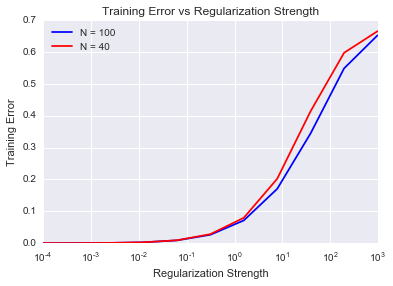

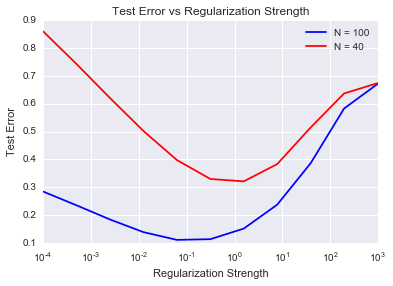

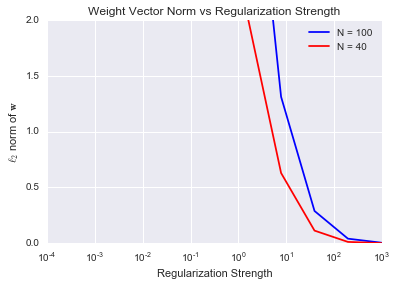

In [106]:
plt.plot(reg_strs, train1_train_errs, 'b-', label='N = 100')
plt.plot(reg_strs, train2_train_errs, 'r-', label='N = 40')
plt.xlabel('Regularization Strength')
plt.ylabel('Training Error')
plt.title('Training Error vs Regularization Strength')
plt.xscale('log')
plt.legend(loc='best')
plt.savefig("train_err_reg_str")
plt.show()

plt.plot(reg_strs, train1_test_errs, 'b-', label='N = 100')
plt.plot(reg_strs, train2_test_errs, 'r-', label='N = 40')
plt.xlabel('Regularization Strength')
plt.ylabel('Test Error')
plt.title('Test Error vs Regularization Strength')
plt.xscale('log')
plt.legend(loc='best')
plt.savefig("test_err_reg_str")
plt.show()

plt.plot(reg_strs, train1_w_norms, 'b-', label='N = 100')
plt.plot(reg_strs, train2_w_norms, 'r-', label='N = 40')
plt.xlabel('Regularization Strength')
plt.ylabel(r'$\ell_2$ norm of $\mathbf{w}$')
plt.title('Weight Vector Norm vs Regularization Strength')
plt.xscale('log')
plt.legend(loc='best')
axes = plt.gca()
axes.set_ylim([0, 2])
plt.savefig("weight_norms")
plt.show()

In [103]:
train2_w_norms

[58.333127055184349,
 43.404747979584435,
 29.672798596607475,
 18.365524189470577,
 10.117060676475731,
 4.8944212507014644,
 2.0290607284342652,
 0.62852287063773871,
 0.11235400117893432,
 0.011254565759445697,
 0.00099765071782638632,
 1.6793228174134102e+22,
 1.5748488624001263e+165]